In [10]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
sys.path.append('../')
import torch
import torch.nn as nn

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

from src.features import Q_measure, dist_distribution, convex_hull, just_traj
from src.andi_tools import Andi_to_xy, Data_to_xy
from src.training import linnetwork


In [11]:
trajectories, labels = Data_to_xy("../data_generation/test_2d_l.csv","../data_generation/label_2d_l.csv")
labels = torch.FloatTensor(labels)
labels = torch.max(labels, 1)[1]

In [12]:
# Here we create a tuple of features that we want to study 

features = (Q_measure(trajectories, 5),
            convex_hull(trajectories, 5),
            dist_distribution(trajectories),
            just_traj(trajectories)[0],
            just_traj(trajectories)[1]
           )
input_tensor = torch.from_numpy(np.concatenate(features,axis=1)).type(torch.FloatTensor)

In [13]:
model = linnetwork(input_size=input_tensor.shape[1])
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [14]:
# Set random seed for reproducibility.

np.random.seed(10)
split = np.int(0.8*input_tensor.shape[0])

train_input, train_labels = input_tensor[:split,:], labels[:split]
test_input, test_labels = input_tensor[split:,:], labels[split:]


<ipython-input-14-fdfa2cf94da2>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(0.8*input_tensor.shape[0])


In [15]:
model.train()
epoch = 10000
for epoch in range(epoch):    
    optimizer.zero_grad()    # Forward pass
    y_pred = model(train_input)    # Compute Loss
    loss = criterion(y_pred.squeeze(), train_labels)
    if epoch % 1000 == 0 :
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 0: train loss: 1.6402573585510254
Epoch 1000: train loss: 0.9074543118476868
Epoch 2000: train loss: 0.9049854278564453
Epoch 3000: train loss: 0.9048867225646973
Epoch 4000: train loss: 0.9048603177070618
Epoch 5000: train loss: 0.9048489332199097
Epoch 6000: train loss: 0.9048439860343933
Epoch 7000: train loss: 0.904839277267456
Epoch 8000: train loss: 0.904837965965271
Epoch 9000: train loss: 0.9048366546630859


In [16]:
solution =  model(test_input)
after_train = criterion(solution,test_labels)


In [17]:
prediction = torch.max(solution, 1)[1]

In [18]:
nonzero = np.count_nonzero(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())
tot = len(np.argmax(solution.detach().numpy(),axis=1)-test_labels.detach().numpy())

In [19]:
(tot-nonzero)/tot

0.91

# Using Captum to find model interpretability

To compute the integrated gradients, we use the attribute method of the IntegratedGradients object. The method takes tensor(s) of input examples (matching the forward function of the model), and returns the input attributions for the given examples. We also have to provide the target label. 

The input tensor provided should require grad, so we call requires\_grad\_ on the tensor. The attribute method also takes a baseline, which is the starting point from which gradients are integrated. The default value is just the 0 tensor, which is a reasonable baseline / default for this task. 

The returned values of the attribute method are the attributions, which match the size of the given inputs, and delta, which approximates the error between the approximated integral and true integral.

In [20]:
ig = IntegratedGradients(model)

considering we have four classification categories we have to calculate the attribute for all these different output categories. We average this score over all the samples (axis=0). 

In [21]:
attr_list = [np.mean(ig.attribute(input_tensor,target=i, return_convergence_delta=True)[0].detach().numpy(), axis=0) for i in [0,1,2,3,4]]

We calculate the position along the input vector corresponing to the different feature to distinguish between the different categories. In this example we have three different features. Finally we average the score 

In [22]:
f_sizes = np.cumsum([0]+[np.shape(i)[1] for i in features])
attr_new = [np.array([np.mean(np.abs(k[f_sizes[i]:f_sizes[i+1]])) for i in np.arange(0,len(f_sizes)-1)]) for k in attr_list]
attr_new = [i/np.sum(i)for i in attr_new]

In [23]:
feature_names = ('Q-measure','Convex Hull','Distance travelled','x_traj','y_traj')
x_pos = (np.arange(len(feature_names)))

This is the relative importance of the three different features in identifying 

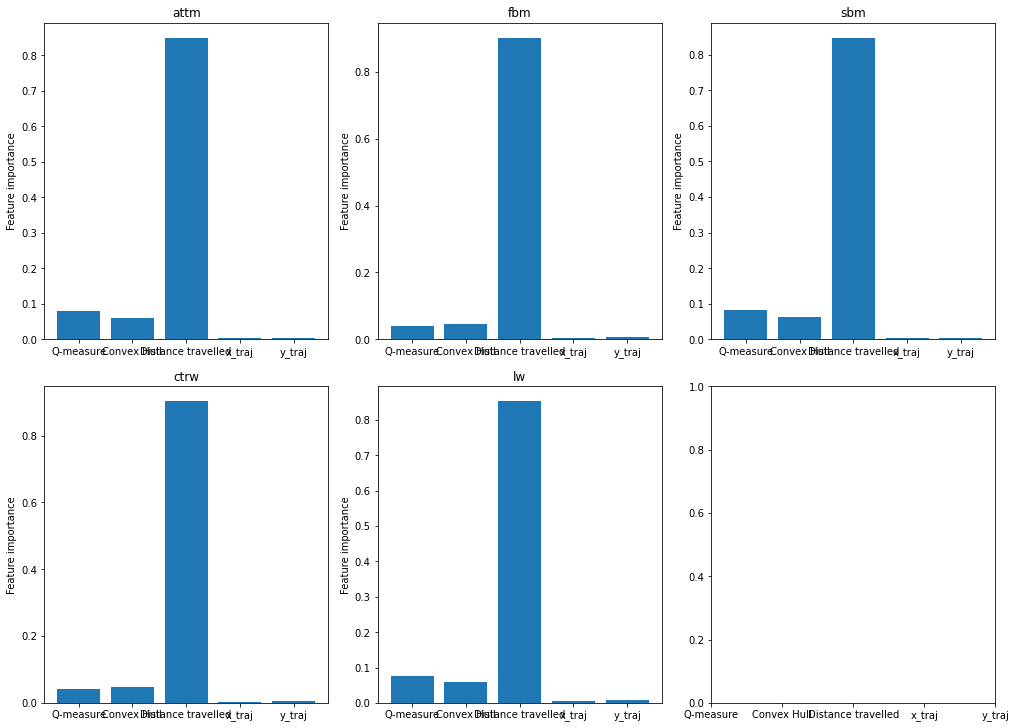

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=3, constrained_layout=True, figsize=(14,10))

axs[0,0].set_title('attm')
axs[0,0].set_ylabel('Feature importance')
axs[0,0].bar(x_pos, attr_new[0], align='center')

axs[1,0].bar(x_pos, attr_new[1], align='center')
axs[1,0].set_ylabel('Feature importance')
axs[1,0].set_title('ctrw')


axs[0,1].bar(x_pos, attr_new[2], align='center')
axs[0,1].set_ylabel('Feature importance')
axs[0,1].set_title('fbm')

axs[1,1].bar(x_pos, attr_new[3], align='center')
axs[1,1].set_ylabel('Feature importance')
axs[1,1].set_title('lw')

axs[0,2].bar(x_pos, attr_new[4], align='center')
axs[0,2].set_ylabel('Feature importance')
axs[0,2].set_title('sbm')

plt.setp(axs, xticks=x_pos, xticklabels=feature_names)
plt.show()